In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from tabulate import tabulate
from tqdm import tqdm
import random

import argparse
import warnings
import os
from datetime import datetime
import time
import math

In [6]:
import os
# Move from notebooks to MagNav
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

A:\Documents\GitHub\MagNav\notebooks
A:\Documents\GitHub\MagNav


In [8]:
import src.magnav as magnav

In [1]:

#--- Functions ---#

def trim_data(data,seq_length):
    # Remove excessive data that cannot be in a full sequence
    if (len(data)%seq_length) != 0:
        data = data[:-(len(data)%seq_length)]
    else:
        pass
        
    return data


# class MagNavDataset(Dataset):
#     # split can be 'Train', 'Val', 'Test'
#     def __init__(self, df, seq_length, split):
        
#         self.seq_length = seq_length
        
#         # Get list of features
#         self.features   = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        
#         if split == 'train':
            
#             # Keeping only 1003, 1002, 1006 and 1004 flight sections for training except 1002.14
#             sections = np.concatenate([df2.LINE.unique(),df3.LINE.unique(),df4.LINE.unique(),df6.LINE.unique()]).tolist()
#             self.sections = sections
            
#             mask_train = pd.Series(dtype=bool)
#             for line in sections:
#                 mask  = (df.LINE == line)
#                 mask_train = mask|mask_train
            
#             # Split in X, y for training
#             X_train    = df.loc[mask_train,self.features]
#             y_train    = df.loc[mask_train,'IGRFMAG1']
            
#             # Removing data that can't fit in full sequence and convert it to torch tensor
#             self.X = torch.t(trim_data(torch.tensor(X_train.to_numpy(),dtype=torch.float32),seq_length))
#             self.y = trim_data(torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
#         elif split == 'val':
            
#             # Selecting 1007 for validation
#             val_sections = df7.LINE.unique().tolist()
#             val_sections.remove(1007.06)
#             self.sections = val_sections
            
#             mask_val = pd.Series(dtype=bool)
#             for line in val_sections:
#                 mask  = (df.LINE == line)
#                 mask_val = mask|mask_val
            
#             # Split in X, y for validation
#             X_val      = df.loc[mask_val,self.features]
#             y_val      = df.loc[mask_val,'IGRFMAG1']
            
#             # Removing data that can't fit in full sequence and convert it to torch tensor
#             self.X = torch.t(trim_data(torch.tensor(X_val.to_numpy(),dtype=torch.float32),seq_length))
#             self.y = trim_data(torch.tensor(np.reshape(y_val.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
        
#         elif split == 'test':
            
#             # Slecting flight 1007 as test
#             mask_test = pd.Series(dtype=bool)
# #             for line in df7.LINE.unique():
#             mask_test  = (df.LINE == 1007.06)
# #                 mask_test = mask|mask_test
            
#             # Split in X, y for test
#             X_test     = df.loc[mask_test,self.features]
#             y_test     = df.loc[mask_test,'IGRFMAG1']
            
#             # Removing data that can't fit in full sequence and convert it to torch tensor
#             self.X = torch.t(trim_data(torch.tensor(X_test.to_numpy(),dtype=torch.float32),seq_length))
#             self.y = trim_data(torch.tensor(np.reshape(y_test.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)

#     def __getitem__(self, index):
#         X = self.X[:,index:(index+self.seq_length)]
#         y = self.y[index+self.seq_length-1]
#         return X, y
    
#     def __len__(self):
#         return len(torch.t(self.X))-self.seq_length
class MagNavDataset(Dataset):
    # split can be 'Train', 'Val', 'Test'
    def __init__(self, df, seq_length, n_fold, split):
        
        self.seq_length = seq_length
        
        # Get list of features
        self.features = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        
        # Get train sections for fold n
        train_fold_0 = np.concatenate([df2.LINE.unique(),df3.LINE.unique(),df4.LINE.unique(),df6.LINE.unique()]).tolist()
        test_fold_0  = df7.LINE.unique().tolist()
        
        train_fold_1 = np.concatenate([df3.LINE.unique(),df4.LINE.unique(),df6.LINE.unique(),df7.LINE.unique()]).tolist()
        test_fold_1  = df2.LINE.unique().tolist()
        
        train_fold_2 = np.concatenate([df4.LINE.unique(),df6.LINE.unique(),df7.LINE.unique(),df2.LINE.unique()]).tolist()
        test_fold_2  = df3.LINE.unique().tolist()
        
        if n_fold == 0:
            self.train_sections = train_fold_0
            self.test_sections = test_fold_0
        elif n_fold == 1:
            self.train_sections = train_fold_1
            self.test_sections = test_fold_1
        elif n_fold == 2:
            self.train_sections = train_fold_2
            self.test_sections = test_fold_2
        
        
        if split == 'train':
            
            mask_train = pd.Series(dtype=bool)
            for line in self.train_sections:
                mask  = (df.LINE == line)
                mask_train = mask|mask_train
            
            # Split in X, y for training
            X_train    = df.loc[mask_train,self.features]
            y_train    = df.loc[mask_train,'IGRFMAG1']
            
            # Removing data that can't fit in full sequence and convert it to torch tensor
            self.X = torch.t(trim_data(torch.tensor(X_train.to_numpy(),dtype=torch.float32),seq_length))
            self.y = trim_data(torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
        elif split == 'test':
            
            mask_test = pd.Series(dtype=bool)
            for line in self.test_sections:
                mask  = (df.LINE == line)
                mask_test = mask|mask_test
            
            # Split in X, y for test
            X_test      = df.loc[mask_test,self.features]
            y_test      = df.loc[mask_test,'IGRFMAG1']
            
            # Removing data that can't fit in full sequence and convert it to torch tensor
            self.X = torch.t(trim_data(torch.tensor(X_test.to_numpy(),dtype=torch.float32),seq_length))
            self.y = trim_data(torch.tensor(np.reshape(y_test.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)

    def __getitem__(self, index):
        X = self.X[:,index:(index+self.seq_length)]
        y = self.y[index+self.seq_length-1]
        return X, y
    
    def __len__(self):
        return len(torch.t(self.X))-self.seq_length


class RMSELoss(torch.nn.Module):
    
    def __init__(self):
        super(RMSELoss,self).__init__()
        
    def forward(self,yhat,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(yhat,y)+1e-6)
        return loss 


class LSTM(torch.nn.Module):
    def __init__(self, seq_len):
        super(LSTM, self).__init__()
        self.lstm1 = torch.nn.LSTM(seq_len, 64, 1, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.lstm2 = torch.nn.LSTM(64, 32, 2, batch_first=True)
        self.lstm3 = torch.nn.LSTM(32, 16, 2, batch_first=True)
        self.fc = torch.nn.Linear(16,1)
    
    def forward(self, x):
        h1 = torch.zeros(1, x.size(0), 64).to('cuda')
        c1 = torch.zeros(1, x.size(0), 64).to('cuda')
        
        h2 = torch.zeros(2, x.size(0), 32).to('cuda')
        c2 = torch.zeros(2, x.size(0), 32).to('cuda')
    
        h3 = torch.zeros(2, x.size(0), 16).to('cuda')
        c3 = torch.zeros(2, x.size(0), 16).to('cuda')
        
        out, hidden = self.lstm1(x, (h1,c1))
        out = self.dropout(out)
        out, hidden = self.lstm2(out, (h2,c2))
        out, hidden = self.lstm3(out, (h3,c3))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out
    
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.fc = torch.nn.Linear(hidden_size,1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to('cuda')
        
        out, _ = self.gru(x,h0)
        
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out
    
class flex_LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(flex_LSTM).__init__()
        
        self.lstms = torch.nn.ModuleList()
        
        for i,hidden_size in enumerate(hidden_sizes):
            input_size = input_size if i == 0 else hidden_sizes[i-1]
            self.lstms.append(torch.nn.LSTM(input_size, hidden_size, 1))
        
        
            
    
    
def make_training(model,EPOCHS):

    optimizer = torch.optim.Adam(model.parameters(),lr=2e-4) 
    
    batch_bar = tqdm(total=len(train)//BATCH_SIZE,unit="batch",desc='Training',leave=False)
    epoch_bar = tqdm(total=EPOCHS,unit="epoch",desc='Training')

    train_loss_history = []
    val_loss_history = []
    pred_history = []

    for epoch in range(EPOCHS):

        #---TRAIN---#

        train_running_loss = 0.

        # Make sure gradient tracking is on, and do a pass over the data
        model.train()
        
        batch_bar.reset()
        # Enumerate allow to track batch index and intra-epoch reporting 
        for batch_index, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Make prediction for this batch
            predictions = model(inputs)

            # Compute the loss
            loss = criterion(predictions, labels)

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Calculate gradients
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            train_running_loss += loss.item()
            
            batch_bar.set_postfix(train_loss=train_running_loss/(batch_index+1),lr=optimizer.param_groups[0]['lr'])
            batch_bar.update()

        train_loss = train_running_loss / batch_index
        train_loss_history.append(train_loss)

        #---VALIDATION---#

        val_running_loss = 0.
        
        preds = []
        
        model.eval()
        
        with torch.no_grad():
            
            for batch_index, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                # Make prediction
                predictions = model(inputs)

                # Compute the loss
                loss = criterion(predictions, labels)

                # Gather data and report
                val_running_loss += loss.item()
                preds.append(predictions.cpu())
                
            preds = np.concatenate(preds)
            pred_history.append(preds)
            val_loss = val_running_loss / batch_index
            val_loss_history.append(val_loss)
        
        epoch_bar.set_postfix(train_loss=train_loss,val_loss=val_loss,lr=optimizer.param_groups[0]['lr'])
        epoch_bar.update()

    return train_loss_history, val_loss_history, pred_history

    
#--- Main ---#

if __name__ == "__main__":
    
    # Start timer
    start_time = time.time()
    
    # Remove UserWarnings from Python
    warnings.filterwarnings("ignore", category=UserWarning) 
    
    # Reproducibility
    torch.manual_seed(27)
    random.seed(27)
    np.random.seed(27)
    
    EPOCHS     = 35#args.epochs
    BATCH_SIZE = 64#args.batch
    DEVICE     = 'cuda'#args.device
    SEQ_LEN    = 25#args.seq
    
    # Import Data
    
    df2 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1002')
    df3 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1003')
    df4 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1004')
    df6 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1006')
    df7 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1007')
    
    scaling = 'none'
    
                #     print('Data scaling Done\n')
    
    # Train, Validation, Test set
    df_concat = pd.concat([df2,df3,df4,df6,df7],ignore_index=True,axis=0)

    train = MagNavDataset(df_concat,seq_length=SEQ_LEN, n_fold=0, split='train')
    val   = MagNavDataset(df_concat,seq_length=SEQ_LEN, n_fold=0, split='test')
    
    # Dataloaders
    train_loader  = DataLoader(train,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=0,
                           pin_memory=False)

    val_loader    = DataLoader(val,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               num_workers=0,
                               pin_memory=False)
    
    print('Data split Done')
    
    # Model
#     model = LSTM(SEQ_LEN,16,3).to(DEVICE) #16,3 pas trop mal pour LSTM avec seq = 25
#     model.name = 'LSTM'
    
    model = LSTM(SEQ_LEN).to(DEVICE)
    model.name = 'LSTM'
    print(model)
    
    # Loss
    criterion = torch.nn.MSELoss()
    
#     Training
    train_loss_history, val_loss_history, pred_history = make_training(model,EPOCHS)

Data split Done
LSTM(
  (lstm1): LSTM(25, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 32, num_layers=2, batch_first=True)
  (lstm3): LSTM(32, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


Training:  69%|████████████████▌       | 5999/8707 [00:31<00:15, 178.80batch/s, lr=0.0002, train_loss=8.79e+3]

KeyboardInterrupt: 

Training:  69%|████████████████▌       | 6000/8707 [00:51<00:15, 178.80batch/s, lr=0.0002, train_loss=8.79e+3]

In [ ]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

In [ ]:
plt.plot(pred_history[])

In [ ]:
import matplotlib.animation

In [ ]:
%%capture
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import numpy as np

num_val = len(pred_history[0])
frames = len(pred_history)

fig, ax1 = plt.subplots(1,1,figsize=[20,5])
line, = ax1.plot(np.linspace(0,num_val-1,num_val),pred_history[0])
ax1.set_ylim([-600,600])
ax1.grid()
ax1.set_ylabel('[nT]')
ax1.set_xlabel('Time Step')
ax1.set_title('RNN fitting to time series')

def animate(i):
    line.set_data(np.linspace(0,num_val-1,num_val),pred_history[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=200)

In [ ]:
ani

In [ ]:
writegif = matplotlib.animation.PillowWriter(fps=8)
ani.save('rnnanim.gif',writer=writegif)

In [ ]:
test  = MagNavDataset(df_concat,seq_length=25,split='test')
test_loader    = DataLoader(test,
                       batch_size=64,
                       shuffle=False,
                       num_workers=0,
                       pin_memory=False)
preds = []

for batch_index, (inputs, labels) in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
        preds.append(model(inputs.to('cuda')).cpu())
preds = np.concatenate(preds)

In [ ]:
import magnav
plt.figure(figsize=[12,10])
plt.plot(preds,label='Prediction')
plt.plot(test.y,label='Truth')
RMSE = magnav.rmse(preds,test.y[25:],False)
plt.text(0.005,0.975,f'RMSE={RMSE:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6),transform=plt.gca().transAxes)
plt.grid()
plt.title('Prediction for flight section 1007')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('[nT]')
plt.show()

In [ ]:
np.std(preds-test.y[25:].numpy())

In [ ]:
hidden_sizess = [100,50,50,25,25]
input_size = 11
for i,hidden_size in enumerate(hidden_sizes):
    
    input_size = input_size if i == 0 else hidden_sizes[i-1]
    print(input_size,hidden_size)

In [ ]:
for k in range(1,5):
    if k == 3:
        print("yo")
        continue
    print(k)

In [ ]:
num_layers = 3
for k in range(num_layers):
    if k == num_layers-1:
        print('ouais')

    print(k)

In [ ]:
import os
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna
from optuna.trial import TrialState
from datetime import datetime
import joblib


class LSTM(torch.nn.Module):
    
    def __init__(self, seq_len, drop_lstm1, hidden_size, num_layers, num_LSTM, num_linear, num_neurons):
        
        super(LSTM, self).__init__()
        self.num_LSTM = num_LSTM
        self.num_linear = num_linear
        self.hidden_size = hidden_size
        self.drop_lstm1 = drop_lstm1
        self.num_layers = num_layers
        self.lstms = nn.ModuleList()
        self.linears = nn.ModuleList()
        
        for k in range(num_LSTM):
            if k == 0:
                self.lstms.append(nn.LSTM(seq_len, hidden_size[0], num_layers[0], batch_first=True))
                continue
                
            self.lstms.append(nn.LSTM(hidden_size[k-1], hidden_size[k], num_layers[k], batch_first=True))
            
        for n in range(num_linear):
            if n == 0:
                self.linears.append(nn.Linear(hidden_size[-1], num_neurons[0]))
                continue
            
            self.linears.append(nn.Linear(num_neurons[n-1], num_neurons[n]))
        
        self.linears.append(nn.Linear(num_neurons[-1],1))
            
        for k in range(num_LSTM):
            nn.init.kaiming_normal_(self.lstms[k]._parameters['weight_ih_l0'])
            nn.init.kaiming_normal_(self.lstms[k]._parameters['weight_hh_l0'])
            if self.lstms[k].bias is not None:
                nn.init.constant_(self.lstms[k]._parameters['bias_ih_l0'], 0)
                nn.init.constant_(self.lstms[k]._parameters['bias_hh_l0'], 0)
        
        for k in range(num_linear):
            nn.init.kaiming_normal_(self.linears[k].weight)
            if self.linears[k].bias is not None:
                nn.init.constant_(self.linears[k].bias, 0)

            
    def forward(self, x):
        
        for k, lstm_k in enumerate(self.lstms):
            if k == 0:
                h = torch.zeros(self.num_layers[k], x.size(0), self.hidden_size[k]).to('cuda')
                c = torch.zeros(self.num_layers[k], x.size(0), self.hidden_size[k]).to('cuda')

                out, _ = lstm_k(x, (h,c))
                out = F.dropout(out)
                continue
                                   
            h = torch.zeros(self.num_layers[k], x.size(0), self.hidden_size[k]).to('cuda')
            c = torch.zeros(self.num_layers[k], x.size(0), self.hidden_size[k]).to('cuda')

            out, _ = lstm_k(out, (h,c))
        
        out = out[:, -1, :]
        
        for k, linear_k in enumerate(self.linears):
            if k == self.num_linear:
                out = linear_k(out)
                return out
            
            out = F.relu(linear_k(out))

In [ ]:
def trim_data(data,seq_length):
    # Remove excessive data that cannot be in a full sequence
    if (len(data)%seq_length) != 0:
        data = data[:-(len(data)%seq_length)]
    else:
        pass
        
    return data

In [ ]:
class MagNavDataset(Dataset):
    # split can be 'Train', 'Val', 'Test'
    def __init__(self, df, seq_length, n_fold, split):
        
        self.seq_length = seq_length
        
        # Get list of features
        self.features = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        
        # Get train sections for fold n
        train_fold_0 = np.concatenate([df2.LINE.unique(),df3.LINE.unique(),df4.LINE.unique(),df6.LINE.unique()]).tolist()
        test_fold_0  = df7.LINE.unique().tolist()
        
        train_fold_1 = np.concatenate([df3.LINE.unique(),df4.LINE.unique(),df6.LINE.unique(),df7.LINE.unique()]).tolist()
        test_fold_1  = df2.LINE.unique().tolist()
        
        train_fold_2 = np.concatenate([df4.LINE.unique(),df6.LINE.unique(),df7.LINE.unique(),df2.LINE.unique()]).tolist()
        test_fold_2  = df3.LINE.unique().tolist()
        
        if n_fold == 0:
            self.train_sections = train_fold_0
            self.test_sections = test_fold_0
        elif n_fold == 1:
            self.train_sections = train_fold_1
            self.test_sections = test_fold_1
        elif n_fold == 2:
            self.train_sections = train_fold_2
            self.test_sections = test_fold_2
        
        
        if split == 'train':
            
            mask_train = pd.Series(dtype=bool)
            for line in self.train_sections:
                mask  = (df.LINE == line)
                mask_train = mask|mask_train
            
            # Split in X, y for training
            X_train    = df.loc[mask_train,self.features]
            y_train    = df.loc[mask_train,'IGRFMAG1']
            
            # Removing data that can't fit in full sequence and convert it to torch tensor
            self.X = torch.t(trim_data(torch.tensor(X_train.to_numpy(),dtype=torch.float32),seq_length))
            self.y = trim_data(torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
        elif split == 'test':
            
            mask_test = pd.Series(dtype=bool)
            for line in self.test_sections:
                mask  = (df.LINE == line)
                mask_test = mask|mask_test
            
            # Split in X, y for test
            X_test      = df.loc[mask_test,self.features]
            y_test      = df.loc[mask_test,'IGRFMAG1']
            
            # Removing data that can't fit in full sequence and convert it to torch tensor
            self.X = torch.t(trim_data(torch.tensor(X_test.to_numpy(),dtype=torch.float32),seq_length))
            self.y = trim_data(torch.tensor(np.reshape(y_test.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)

    def __getitem__(self, index):
        X = self.X[:,index:(index+self.seq_length)]
        y = self.y[index+self.seq_length-1]
        return X, y
    
    def __len__(self):
        return len(torch.t(self.X))-self.seq_length

In [ ]:
def train(network, optimizer, seq_len, n_fold, batch_size):
    
    train_data = MagNavDataset(df_concat, seq_length=seq_len, n_fold=n_fold,split='train') # Train data
    train_loader  = DataLoader(train_data,                                            # Train data loader
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=0,
                               pin_memory=False)
    
    network.train()                                                                   # Set the module in training mode
    
    for batch_i, (data, target) in enumerate(train_loader):
        
#         if batch_i * batch_size > number_of_train_examples:                     # Limit training data for faster computation
#             break

        optimizer.zero_grad()                                                         # Clear gradients
        output = network(data.to(device))                                             # Forward propagration
        loss = F.mse_loss(output, target.to(device))                                  # Compute loss (Mean Squared Error)
        loss.backward()                                                               # Compute gradients
        optimizer.step()    

In [ ]:
def validate(network,seq_len, n_fold, batch_size):
    
    val_data   = MagNavDataset(df_concat, seq_length=seq_len, n_fold=n_fold,split='test') # Validation data
    


    val_loader    = DataLoader(val_data,                                              # Validation data loader
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=0,
                               pin_memory=False,
                               drop_last=True)
    
    network.eval()                                                                    # Set module in evaluation mode
    preds = []
    truth = []
    
    with torch.no_grad():                                                             # Disable gradient calculation
        for batch_i, (data, target) in enumerate(val_loader):
            
#             if batch_i * batch_size > number_of_val_examples:                     # Limit validation data for faster computation
#                 break
            
            preds.append(network(data.to(device)))                                    # Forward propagation
            truth.append(target.to(device))                                           # Collecting truth data
            
    preds = torch.cat(preds,dim=1)                                                    # Unification of sequences
    truth = torch.cat(truth,dim=1)
    validation_RMSE = torch.sqrt(F.mse_loss(preds,truth))                             # Compute RMSE
    validation_SNR = compute_SNR(truth.cpu().numpy(),preds.cpu().numpy())
    
    return validation_RMSE

In [2]:
    num_LSTM    = 3                         # Number of LSTM layers
    hidden_size = [8,68,16]         # Hidden size by lstm layers
    num_layers  = [3,8,2]           # Layers by lstm layers
    num_linear  = 3                         # Number of fully connected layers
    num_neurons = [64,32,3]       # Number of neurons for the FC layers
    drop_lstm1  = 0.3                           # Drop for 1st LSTM layer
    seq_len     = 25              # Length of a sequence
    device = "cuda"
    
    model = LSTM(seq_len, drop_lstm1, hidden_size, num_layers, 
                 num_LSTM, num_linear, num_neurons).to(device)                        # Generate the model
    
    optimizer_name = ("Adam")  # Optimizers
    lr             = 0.001                  # Learning rates
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)             # Optimizer set up
    
    df2 = pd.read_hdf('./data/processed/Chall_dataset.h5', key=f'Flt1002')              # Import flight 1002
    df3 = pd.read_hdf('./data/processed/Chall_dataset.h5', key=f'Flt1003')              # Import flight 1003
    df4 = pd.read_hdf('./data/processed/Chall_dataset.h5', key=f'Flt1004')              # Import flight 1004
    df6 = pd.read_hdf('./data/processed/Chall_dataset.h5', key=f'Flt1006')              # Import flight 1006
    df7 = pd.read_hdf('./data/processed/Chall_dataset.h5', key=f'Flt1007')              # Import flight 1007
    
    df_concat = pd.concat([df2,df3,df4,df6,df7], ignore_index=True, axis=0)           # Concatenate data
    
#     n_epochs = trial.suggest_int("n_epochs",2,50)
#     batch_size = int(trial.suggest_discrete_uniform("batch_size",32,2048,32))
    n_epochs = 2
    batch_size = 128
    
    fold_RMSE = []
    
    for n_fold in range(3):
        model = LSTM(seq_len, drop_lstm1, hidden_size, num_layers, num_LSTM, num_linear, num_neurons).to(device) # Generate the model
        print(model)
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)             # Optimizer set up
        for epoch in range(n_epochs):
            train(model, optimizer, seq_len, n_fold, batch_size)                         # Training of the model
            RMSE = validate(model, seq_len, n_fold, batch_size)                           # Evaluate the model
        
        fold_RMSE.append(RMSE)
        trial.report(RMSE, epoch)                                                     # Report values
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()                                     # Prune training (if it is not promising)
            
    total_RMSE = sum(fold_RMSE)/3
    
    print(total_RMSE)

NameError: name 'LSTM' is not defined

In [ ]:
test = MagNavDataset(df_concat, seq_length=32, n_fold=1,split='test') # Validation data

In [ ]:
test.__getitem__(0)[1].size()

In [5]:
df2 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1002')              # Import flight 1002
df3 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1003')              # Import flight 1003
df4 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1004')              # Import flight 1004
df6 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1006')              # Import flight 1006
df7 = pd.read_hdf('../data/processed/Chall_dataset.h5', key=f'Flt1007')              # Import flight 1007

df_concat = pd.concat([df2,df3,df4,df6,df7], ignore_index=True, axis=0)           # Concatenate data

In [7]:
df_concat.describe()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,INS_ACC_X,INS_ACC_Y,INS_ACC_Z,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
count,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000
mean,-866.739462,149.998320,25.722757,2.656956,-0.007116,-0.001967,9.801125,4.279897,3.209615,0.680420,195.979442,1216.832183,-20.614485
std,357.954672,256.205439,0.207510,0.771180,0.887870,0.869604,0.783899,1.293773,2.079876,6.923212,102.015984,802.839799,248.690317
min,-14799.947733,-1131.669624,25.565000,0.721000,-7.366149,-6.812820,1.656503,1.197000,-9.240000,-33.980000,0.000000,158.000000,-868.652000
25%,-1083.094048,11.551914,25.611000,2.131000,-0.218880,-0.189277,9.492046,3.279000,2.150000,-1.210000,118.180000,1002.180000,-163.520000
50%,-848.461127,167.309176,25.721000,2.965000,0.000177,-0.000385,9.801126,4.101000,3.170000,0.260000,181.840000,1003.080000,14.248000
75%,-656.548771,289.203195,25.769000,3.190000,0.218683,0.193209,10.119414,5.192000,4.170000,1.770000,295.730000,1007.020000,106.659250
max,7499.829375,2878.672361,27.906000,3.688000,6.089665,7.133355,17.052216,6.670000,11.410000,42.220000,360.000000,4019.000000,2699.331000


In [19]:
bound=[0,1]
minmax_df = bound[0] + ((bound[1]-bound[0])*(df_concat-df_concat.min())/(df_concat.max()-df_concat.min()))
minmax_df.describe()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,INS_ACC_X,INS_ACC_Y,INS_ACC_Z,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
count,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000,671840.000000
mean,0.624814,0.319591,0.067389,0.652496,0.546904,0.488367,0.529019,0.563292,0.602887,0.454861,0.544387,0.274238,0.237680
std,0.016052,0.063886,0.088641,0.259919,0.065984,0.062354,0.050917,0.236392,0.100720,0.090856,0.283378,0.207936,0.069701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.615112,0.285068,0.019650,0.475228,0.531166,0.474936,0.508943,0.380413,0.551574,0.430052,0.328278,0.218643,0.197628
50%,0.625633,0.323907,0.066638,0.756320,0.547446,0.488481,0.529019,0.530605,0.600969,0.449344,0.505111,0.218876,0.247451
75%,0.634239,0.354302,0.087142,0.832154,0.563684,0.502362,0.549693,0.729947,0.649395,0.469160,0.821472,0.219896,0.273351
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

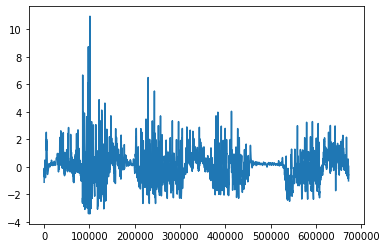

In [10]:
norm_df['IGRFMAG1'].plot()

<AxesSubplot:>

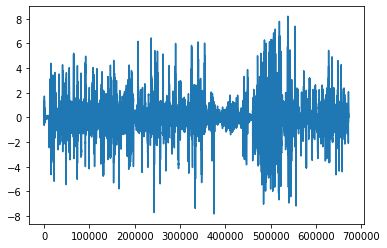

In [13]:
norm_df['INS_ACC_Y'].plot()

In [21]:
import os
# Move from notebooks to MagNav
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/home/nlaoue/projet/MagNav/notebooks
/home/nlaoue/projet/MagNav


In [22]:
import src.magnav as magnav

In [34]:
RMSEno = magnav.rmse(df_concat['TL_comp_mag5_cl'],df_concat['IGRFMAG1'],False)
RMSEyes = magnav.rmse((norm_df['TL_comp_mag5_cl']*df_concat['TL_comp_mag5_cl'].std())+df_concat['TL_comp_mag5_cl'].mean(),(norm_df['IGRFMAG1']*df_concat['IGRFMAG1'].std())+df_concat['IGRFMAG1'].mean(),True)
print(RMSEno,RMSEyes)

181.61645675765092 62.25599064075581


In [9]:
df = pd.read_hdf(r'data/interim/Flt_data.h5', key=f'Flt100{3}')


#---Tolles-Lawson compensation---#

# Get cloverleaf pattern data
flight_number = 2
df_pattern    = pd.read_hdf(r'data/interim/Flt_data.h5',key=f'Flt100{flight_number}')
mask  = (df_pattern.LINE == 1002.20)
tl_cl = df_pattern[mask] # Square Tolles-Lawson pattern

# filter parameters
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# A matrix of Tolles-Lawson
A = magnav.create_TL_A(df['FLUXB_X'],df['FLUXB_Y'],df['FLUXB_Z'])

# Tolles Lawson coefficients computation
TL_coef_3 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG3'],
                              lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG5'],
                              lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

In [13]:
# Magnetometers correction
corr_mag3 = magnav.apply_TL(np.reshape(df['UNCOMPMAG3'].tolist(),(-1,1)),TL_coef_3,A)
df['TL_comp_mag3_cl'] = np.reshape(df['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df['TL_comp_mag5_cl'] = np.reshape(df['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

In [ ]:
    df2 = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt1002')
    df3 = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt1003')
    df4 = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt1004')
    df6 = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt1006')
    df7 = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt1007')

In [28]:
flights_dict = {}
for n in [2,3,4,6,7]:
    df = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt100{n}')
    flights_dict[n] = df

In [30]:
a = flights_dict